In [1]:
%matplotlib inline
import matplotlib


In [29]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
from scipy import ndimage
import os
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
from sklearn.utils import shuffle
import h5py

In [3]:
#load data
print ("loading data")
#iterate over directory and get all png images\n
#imageset = np.empty((7704,64,64,3), dtype='float32')
rootdir = '/home/chsarath/kaushal_project/mug/models/3dw'


def get_image_data(root_dir):
    img_data = np.zeros((36,64,64,3)) # to do start with zero
    cnt = 0
    total_cnt = 0
    
    cur_model =  np.empty((36,64,64,3), dtype='float32')
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            filepath = subdir + os.sep + file
            k += 1
            if filepath.endswith('.png'):
                #print('check')
                if cnt == 36:
                    cnt = 0
                    total_cnt += 1
                    
                    img_data = np.concatenate((img_data,cur_model),axis=0)
                    #print(cur_model)
                    #cur_model =  np.empty((36,64,64,3), dtype='float32')

                cnt += 1
                seq_number = int(filepath.split('-')[-1].split('.')[0])
                cur_model[seq_number] = misc.imread(filepath).astype(np.float32)
                #plt.imshow(cur_model[seq_number]/255)
                #plt.show()
    return img_data
                
                #img_data.concatenate(cur_model)
                

                #imageset[total_cnt*36 + seq_number] = misc.imread(filepath).astype(np.float32)
    #print(len(img_data))
    #return np.asarray(img_data)
    print(img_data.shape)
            
    print ('loading done')

loading data


In [4]:


i = get_image_data('/home/chinmay/work/screenshots/models/chair_train/batch1')
print(i.shape)


#TO-DO Remove first zeros image

(360, 64, 64, 3)


(64, 64, 3)


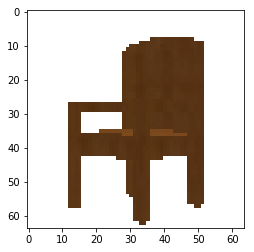

In [5]:
print(i[37].shape)
#print(i[10])

plt.imshow(i[140]/255)
plt.show()

In [8]:

def get_train(data, pairs_per_model):
    W,H,C = 64,64,3
    images_per_model = 36
    pose_W, pose_H, pose_D = 8,8,36

    total_models = int(data.shape[0] / images_per_model)
    print(total_models)
    data_train = np.zeros((total_models * pairs_per_model, W,H,C))
    
    data_ = np.zeros((total_models * pairs_per_model,W,H,C))
    labels_ = np.zeros((total_models * pairs_per_model,W,H,C))
    pose = np.zeros((total_models * pairs_per_model,pose_W,pose_H,pose_D))
    
    for cnt in range(total_models ):
        tmp_data = np.zeros((images_per_model * images_per_model,W,H,C))
        tmp_labels = np.zeros((images_per_model * images_per_model,W,H,C))
        tmp_pose = np.zeros((images_per_model * images_per_model, pose_W,pose_H,pose_D))
        for i in range(images_per_model):
            for j in range(images_per_model):
                num = (j-i) % images_per_model
                pose_tmp = np.zeros(images_per_model)
                pose_tmp[num] = 1
                tmp_pose[i*images_per_model + j] = np.broadcast_to(pose_tmp,(pose_W,pose_H,pose_D))
                tmp_data[i*images_per_model + j] = data[cnt*images_per_model + i]
                tmp_labels[i*images_per_model + j] = data[cnt *images_per_model + j]         
        rand_nums = np.random.randint(0,images_per_model * images_per_model - 1,pairs_per_model)
        data_[cnt*pairs_per_model : (cnt+1)*pairs_per_model] = tmp_data[rand_nums]
        labels_[cnt*pairs_per_model : (cnt+1)*pairs_per_model] = tmp_labels[rand_nums]
        pose[cnt*pairs_per_model : (cnt+1)*pairs_per_model] = tmp_pose[rand_nums]
        
    data_, labels_, pose = shuffle(data_, labels_, pose, random_state=0)
    return data_, labels_, pose

In [9]:
data_, labels_, pose_ = get_train(i,100)


10


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


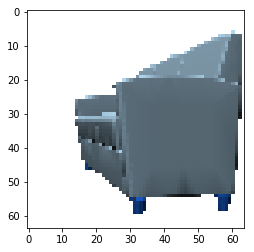

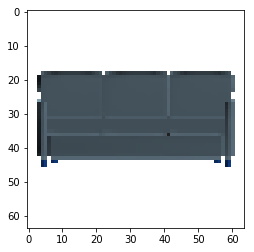

In [25]:

i = 255
print(pose_[i][0][0])
plt.imshow(data_[i][...,::-1]/255)
plt.show()
plt.imshow(labels_[i][...,::-1]/255)
plt.show()


In [ ]:
#normalize data
def normalize(data):
    data *= 2
    data /= 255
    data -= 1
    return data
 
#denormalize data
def denormalize(data):
    data += 1
    data *=  255
    data /= 2
    return data


In [ ]:
tf.reset_default_graph()
#to Reset Tensor Flow Graph

In [ ]:
#defination of my layers
'''
def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b
'''
def conv2d(input, kernel_size, stride, num_filter, name = 'conv2d'):
    with tf.variable_scope(name):
        stride_shape = [1, stride, stride, 1]
        filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

        W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [1, 1, 1, num_filter], initializer = tf.constant_initializer(0.0))
        return tf.nn.conv2d(input, W, stride_shape, padding = 'SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

def deconv2d(input, kernel_size, stride, num_filter):
    filter_shape = [kernel_size, kernel_size, num_filter, input.get_shape()[3]]
    # tf.constant([input.get_shape()[0], input.get_shape()[1]*2, input.get_shape()[1]*2, num_filter], tf.int32)
    input_dim = input.get_shape().as_list()
    batch_size = input_dim[0]
    w = input_dim[1]
    out_shape = tf.stack([batch_size, w*2, w*2, num_filter])    
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer = tf.constant_initializer(0.0))
    stride_shape = [1, stride, stride, 1]
    W = tf.get_variable('w', filter_shape, tf.float32, tf.contrib.layers.xavier_initializer())
    
    return tf.nn.conv2d_transpose(input, W, out_shape, stride_shape) + b

def conv2d_transpose(input, kernel_size, stride, num_filter, name = 'conv2d_transpose'):
    with tf.variable_scope(name):
        stride_shape = [1, stride, stride, 1]
        filter_shape = [kernel_size, kernel_size, num_filter, input.get_shape()[3]]
        output_shape = tf.stack([tf.shape(input)[0], tf.shape(input)[1] * 2, tf.shape(input)[2] * 2, num_filter])

        W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [1, 1, 1, num_filter], initializer = tf.constant_initializer(0.0))
        return tf.nn.conv2d_transpose(input, W, output_shape, stride_shape, padding = 'SAME') + b


def batch_norm(input, is_training):
    out = tf.contrib.layers.batch_norm(input, decay = 0.99, center = True, scale = True,
                                       is_training = is_training, updates_collections = None)
    return out

In [ ]:

class AutoEncoder(object):
    
    def __init__(self):
        self.inputs_ = tf.placeholder(tf.float32, [None, 64, 64, 3])
        self.targets_ = tf.placeholder(tf.float32, [None, 64, 64, 3])
        self.pose_ = tf.placeholder(tf.float32, [None, 8, 8, 36])
        self.is_train = tf.placeholder(tf.bool)
        self.num_epoch = 100
        self.batch_size = 20
        self.num_training = 17000
        self._build_model()
        
    def _encoder_decoder(self):
        with tf.variable_scope('conv1'):
            _ = conv2d(self.inputs_, 3, 2, 16, 'conv1')
            #_ = batch_norm(_, self.is_train)
            _ = tf.nn.relu(_)
            _ = conv2d(_, 3, 2, 32, 'conv2')
            #_ = batch_norm(_, self.is_train)
            _ = tf.nn.relu(_)
            #_ = conv2d(_, 3, 2, 64, 'conv3')
            #_ = tf.nn.relu(_)
            _ = conv2d(_, 3, 2, 64, 'conv4')
            _ = tf.nn.relu(_)
            _ = tf.concat([_, self.pose_], 3)
            #_ = conv2d_transpose(_, 3, 2, 64, 'deconv0')
            #_ = tf.nn.relu(_)
            _ = conv2d_transpose(_, 3, 2, 32, 'deconv1')
            #_ = batch_norm(_, self.is_train)
            _ = tf.nn.relu(_)
            _ = conv2d_transpose(_, 3, 2, 16, 'deconv2')
            #_ = batch_norm(_, self.is_train)
            _ = tf.nn.relu(_)
            _ = conv2d_transpose(_, 3, 2, 3, 'deconv3')
            _ = tf.nn.tanh(_)
            return _

    def _loss(self, labels, logits):
        self.loss_op = tf.reduce_mean(abs(labels - logits))
    
    def _build_optimizer(self):
        global_step = tf.Variable(0,trainable=False)
        lr = tf.train.exponential_decay(5e-4, global_step, 1000, 0.96, staircase=True)
        optimizer = tf.train.AdamOptimizer(lr)
        self.train_op = optimizer.minimize(loss=self.loss_op)

    def _build_model(self):
        self.out = self._encoder_decoder()
        self._loss(self.out, self.targets_)
        self._build_optimizer()
        
    def train(self, sess, X_train, Y_train, pose):
        sess.run(tf.global_variables_initializer())
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for e in range(self.num_epoch):
            for ii in range(X_train.shape[0] // self.batch_size):
                batch = X_train[ii*self.batch_size : (ii+1)*self.batch_size]
                batch_labels = Y_train[ii*self.batch_size : (ii+1)*self.batch_size]
                pose_labels = pose[ii*self.batch_size : (ii+1)*self.batch_size]
                feed_dict = {self.inputs_: batch, self.targets_: batch_labels, self.pose_:pose_labels, self.is_train:True}
                fetches = [self.train_op, self.loss_op]
                _, loss = sess.run(fetches, feed_dict=feed_dict)
            print("Epoch: {}/{}...".format(e+1, self.num_epoch),
                "Training loss: {:.4f}".format(loss))
    
    def evaluate(self, sess, X_eval, Y_eval, pose_eval):
        out = np.zeros(Y_eval.shape)
        for ii in range(X_eval.shape[0] // self.batch_size):
            batch = X_eval[ii*self.batch_size : (ii+1)*self.batch_size]
            batch_labels = Y_eval[ii*self.batch_size : (ii+1)*self.batch_size]
            pose_labels = pose_eval[ii*self.batch_size : (ii+1)*self.batch_size]
            feed_dict = {self.inputs_: batch, self.targets_: batch_labels, self.pose_:pose_labels, self.is_train:False}
            fetches = [self.train_op, self.loss_op, self.out]
            _, loss, out[ii*self.batch_size : (ii+1)*self.batch_size] = sess.run(fetches, feed_dict=feed_dict)
            print ("loss: {:.4f}".format(loss))
        return out

In [ ]:
base_dir = '/home/chinmay/work/screenshots/models/chair_train'

In [ ]:
tf.reset_default_graph()

# Train our sample model
with tf.Session() as sess:
    #with tf.device('/device:gpu:0'):
    model = AutoEncoder()
    model.train(sess, data_train, train_labels, pose_train)
    output = model.evaluate(sess, data_test, test_labels, pose_test)
    saver = tf.train.Saver()
    model_path = saver.save(sess, "saved_models/encoder_pose.ckpt")
    print("Model saved in %s" % model_path)


In [ ]:
other = np.array(output)

print (other.shape)

In [ ]:

other += 1
other *=  255
other /= 2


In [ ]:

tmp = other[1240]
print (tmp.shape)
plt.imshow(tmp/255)
plt.show()

In [ ]:

test_labels += 1
test_labels *=  255
test_labels /= 2




In [ ]:
tmp = test_labels[3102]
print (tmp.shape)
plt.imshow(tmp/255)
plt.show()
print (pose_test[451][0][0])